# Quick Draw Modified RNN

Abel Tadesse <br />
Jason Yi <br />
Richy Chen <br />

## Import Dependencies

In [1]:
import pandas as pd
%matplotlib inline
import os
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()
import numpy as np
import tensorflow as tf
import random
from ast import literal_eval
from sklearn.utils import shuffle
training_set = '../train_simplified/'
from os import listdir
from os.path import isfile, join

ALL_TRAIN_PATHS = [join(training_set, f) for f in listdir(training_set) if isfile(join(training_set, f))]

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

True

# Clean and Preprocess

In [3]:
from ast import literal_eval
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=STROKE_COUNT, 
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5, 
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS[:50]:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)
    
    return full_df

In [4]:
batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 500

In [5]:
train_args = dict(samples=TRAIN_SAMPLES, 
                  start_row=0, 
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES, 
                  start_row=train_args['max_rows']+1, 
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES, 
                 start_row=valid_args['max_rows']+train_args['max_rows']+1, 
                 max_rows=TEST_SAMPLES+25)
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
print(train_df.shape,valid_df.shape,test_df.shape)

(37500, 2) (3750, 2) (25000, 2)


In [6]:

word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

words 50 => The Eiffel Tower, angel, arm, bench, bicycle, blueberry, book, boomerang, bush, butterfly, calendar, cat, compass, cooler, dishwasher, dragon, dresser, face, fan, fish, flower, goatee, hammer, harp, lobster, lollipop, moon, mouth, mug, nose, paintbrush, paper clip, peanut, peas, pliers, rain, saxophone, scorpion, speedboat, spoon, stethoscope, streetlight, toilet, toothbrush, tractor, truck, vase, whale, zebra, zigzag


# Stroke-based Classification

In [7]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)

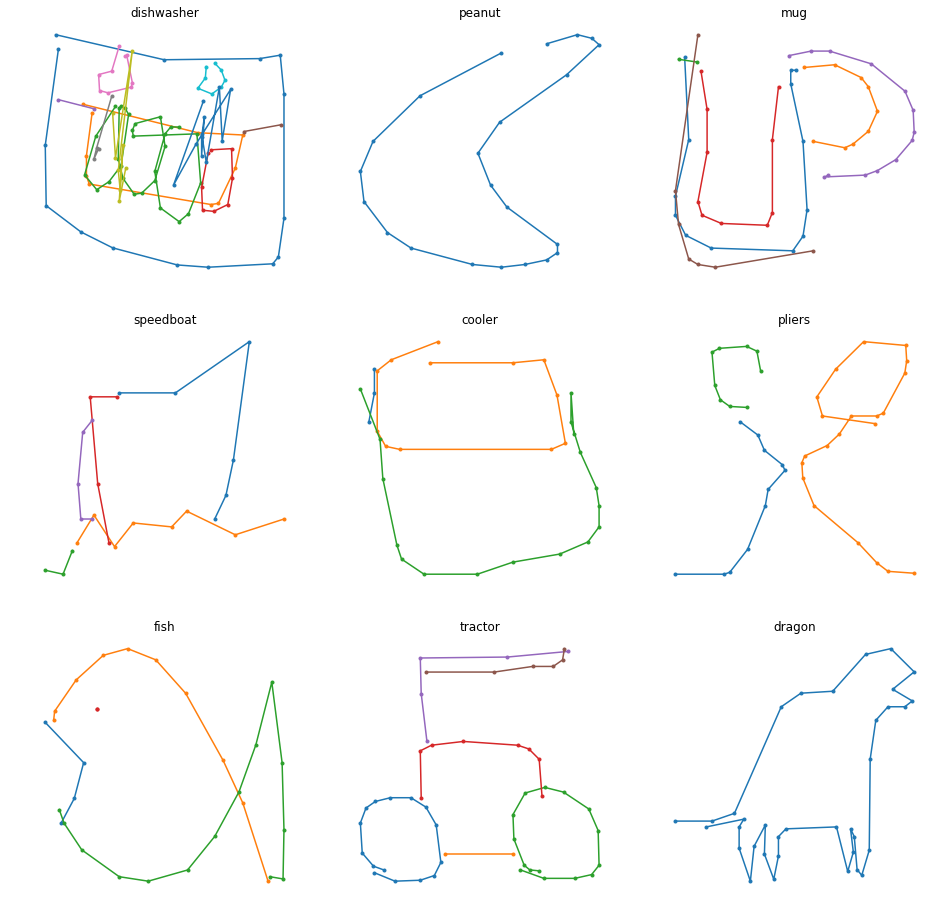

In [8]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

## RNN Model

In [9]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D
from keras.layers import CuDNNLSTM as LSTM 
stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)+train_X.shape[2:]))

stroke_read_model.add(Bidirectional(LSTM(50, return_sequences=True)))
stroke_read_model.add(GlobalMaxPool1D())
stroke_read_model.add(Dense(50, activation="relu"))
stroke_read_model.add(Dropout(0.1))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'sigmoid'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, 3)           12        
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 100)         22000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
Total params: 29,612
Trainable params: 29,606
Non-trainable params: 6
_________________________________________________________________


In [10]:
weight_path="{}_weights.hdf5".format('modified_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                   verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/abelleulseged/miniconda3/envs/cs152/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [11]:
import time
start_time = time.time()
# train and clearn the training output
from IPython.display import clear_output
history = stroke_read_model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 100,
                      callbacks = callbacks_list)
# clear_output()
print("Training for 100 epochs took {} mins".format(((time.time() - start_time))/60))

Train on 37500 samples, validate on 3750 samples
Epoch 1/100
37500/37500 [==============================] - 7s 186us/step - loss: 3.9060 - categorical_accuracy: 0.0238 - top_3_accuracy: 0.0714 - val_loss: 3.8933 - val_categorical_accuracy: 0.0381 - val_top_3_accuracy: 0.0936

Epoch 00001: val_loss improved from inf to 3.89327, saving model to modified_lstm_model_weights.hdf5
Epoch 2/100
37500/37500 [==============================] - 4s 98us/step - loss: 3.8857 - categorical_accuracy: 0.0397 - top_3_accuracy: 0.1043 - val_loss: 3.8665 - val_categorical_accuracy: 0.0419 - val_top_3_accuracy: 0.1179

Epoch 00002: val_loss improved from 3.89327 to 3.86648, saving model to modified_lstm_model_weights.hdf5
Epoch 3/100
37500/37500 [==============================] - 4s 98us/step - loss: 3.8531 - categorical_accuracy: 0.0439 - top_3_accuracy: 0.1143 - val_loss: 3.8211 - val_categorical_accuracy: 0.0445 - val_top_3_accuracy: 0.1187

Epoch 00003: val_loss improved from 3.86648 to 3.82108, saving 


Epoch 00025: val_loss improved from 2.55547 to 2.53045, saving model to modified_lstm_model_weights.hdf5
Epoch 26/100
37500/37500 [==============================] - 4s 99us/step - loss: 2.6119 - categorical_accuracy: 0.2854 - top_3_accuracy: 0.5278 - val_loss: 2.4909 - val_categorical_accuracy: 0.3395 - val_top_3_accuracy: 0.5840

Epoch 00026: val_loss improved from 2.53045 to 2.49092, saving model to modified_lstm_model_weights.hdf5
Epoch 27/100
37500/37500 [==============================] - 4s 99us/step - loss: 2.5832 - categorical_accuracy: 0.2938 - top_3_accuracy: 0.5365 - val_loss: 2.4613 - val_categorical_accuracy: 0.3496 - val_top_3_accuracy: 0.5941

Epoch 00027: val_loss improved from 2.49092 to 2.46127, saving model to modified_lstm_model_weights.hdf5
Epoch 28/100
37500/37500 [==============================] - 4s 100us/step - loss: 2.5518 - categorical_accuracy: 0.3037 - top_3_accuracy: 0.5476 - val_loss: 2.4367 - val_categorical_accuracy: 0.3645 - val_top_3_accuracy: 0.5989



Epoch 00050: val_loss improved from 2.04831 to 2.02708, saving model to modified_lstm_model_weights.hdf5
Epoch 51/100
37500/37500 [==============================] - 4s 99us/step - loss: 2.1126 - categorical_accuracy: 0.4206 - top_3_accuracy: 0.6638 - val_loss: 2.0102 - val_categorical_accuracy: 0.4571 - val_top_3_accuracy: 0.6869

Epoch 00051: val_loss improved from 2.02708 to 2.01019, saving model to modified_lstm_model_weights.hdf5
Epoch 52/100
37500/37500 [==============================] - 4s 98us/step - loss: 2.0993 - categorical_accuracy: 0.4238 - top_3_accuracy: 0.6649 - val_loss: 1.9931 - val_categorical_accuracy: 0.4645 - val_top_3_accuracy: 0.6933

Epoch 00052: val_loss improved from 2.01019 to 1.99313, saving model to modified_lstm_model_weights.hdf5
Epoch 53/100
37500/37500 [==============================] - 4s 99us/step - loss: 2.0888 - categorical_accuracy: 0.4274 - top_3_accuracy: 0.6688 - val_loss: 1.9846 - val_categorical_accuracy: 0.4581 - val_top_3_accuracy: 0.7021



dict_keys(['val_loss', 'val_categorical_accuracy', 'val_top_3_accuracy', 'loss', 'categorical_accuracy', 'top_3_accuracy', 'lr'])


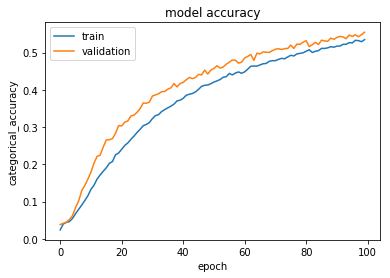

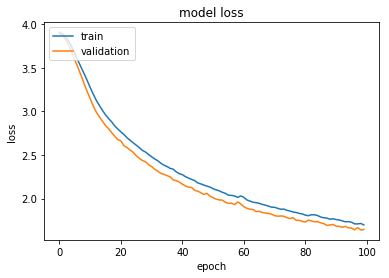

In [12]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
stroke_read_model.load_weights(weight_path)
lstm_results = stroke_read_model.evaluate(test_X, test_y, batch_size = 40)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

25000/25000 [==============================] - 14s 573us/step
Accuracy: 54.0%, Top 3 Accuracy 75.6%


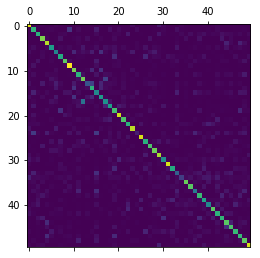

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
test_cat = np.argmax(test_y, 1)
pred_y = stroke_read_model.predict(test_X, batch_size = 4096)
pred_cat = np.argmax(pred_y, 1)
plt.matshow(confusion_matrix(test_cat, pred_cat))

# Point by Point Prediction

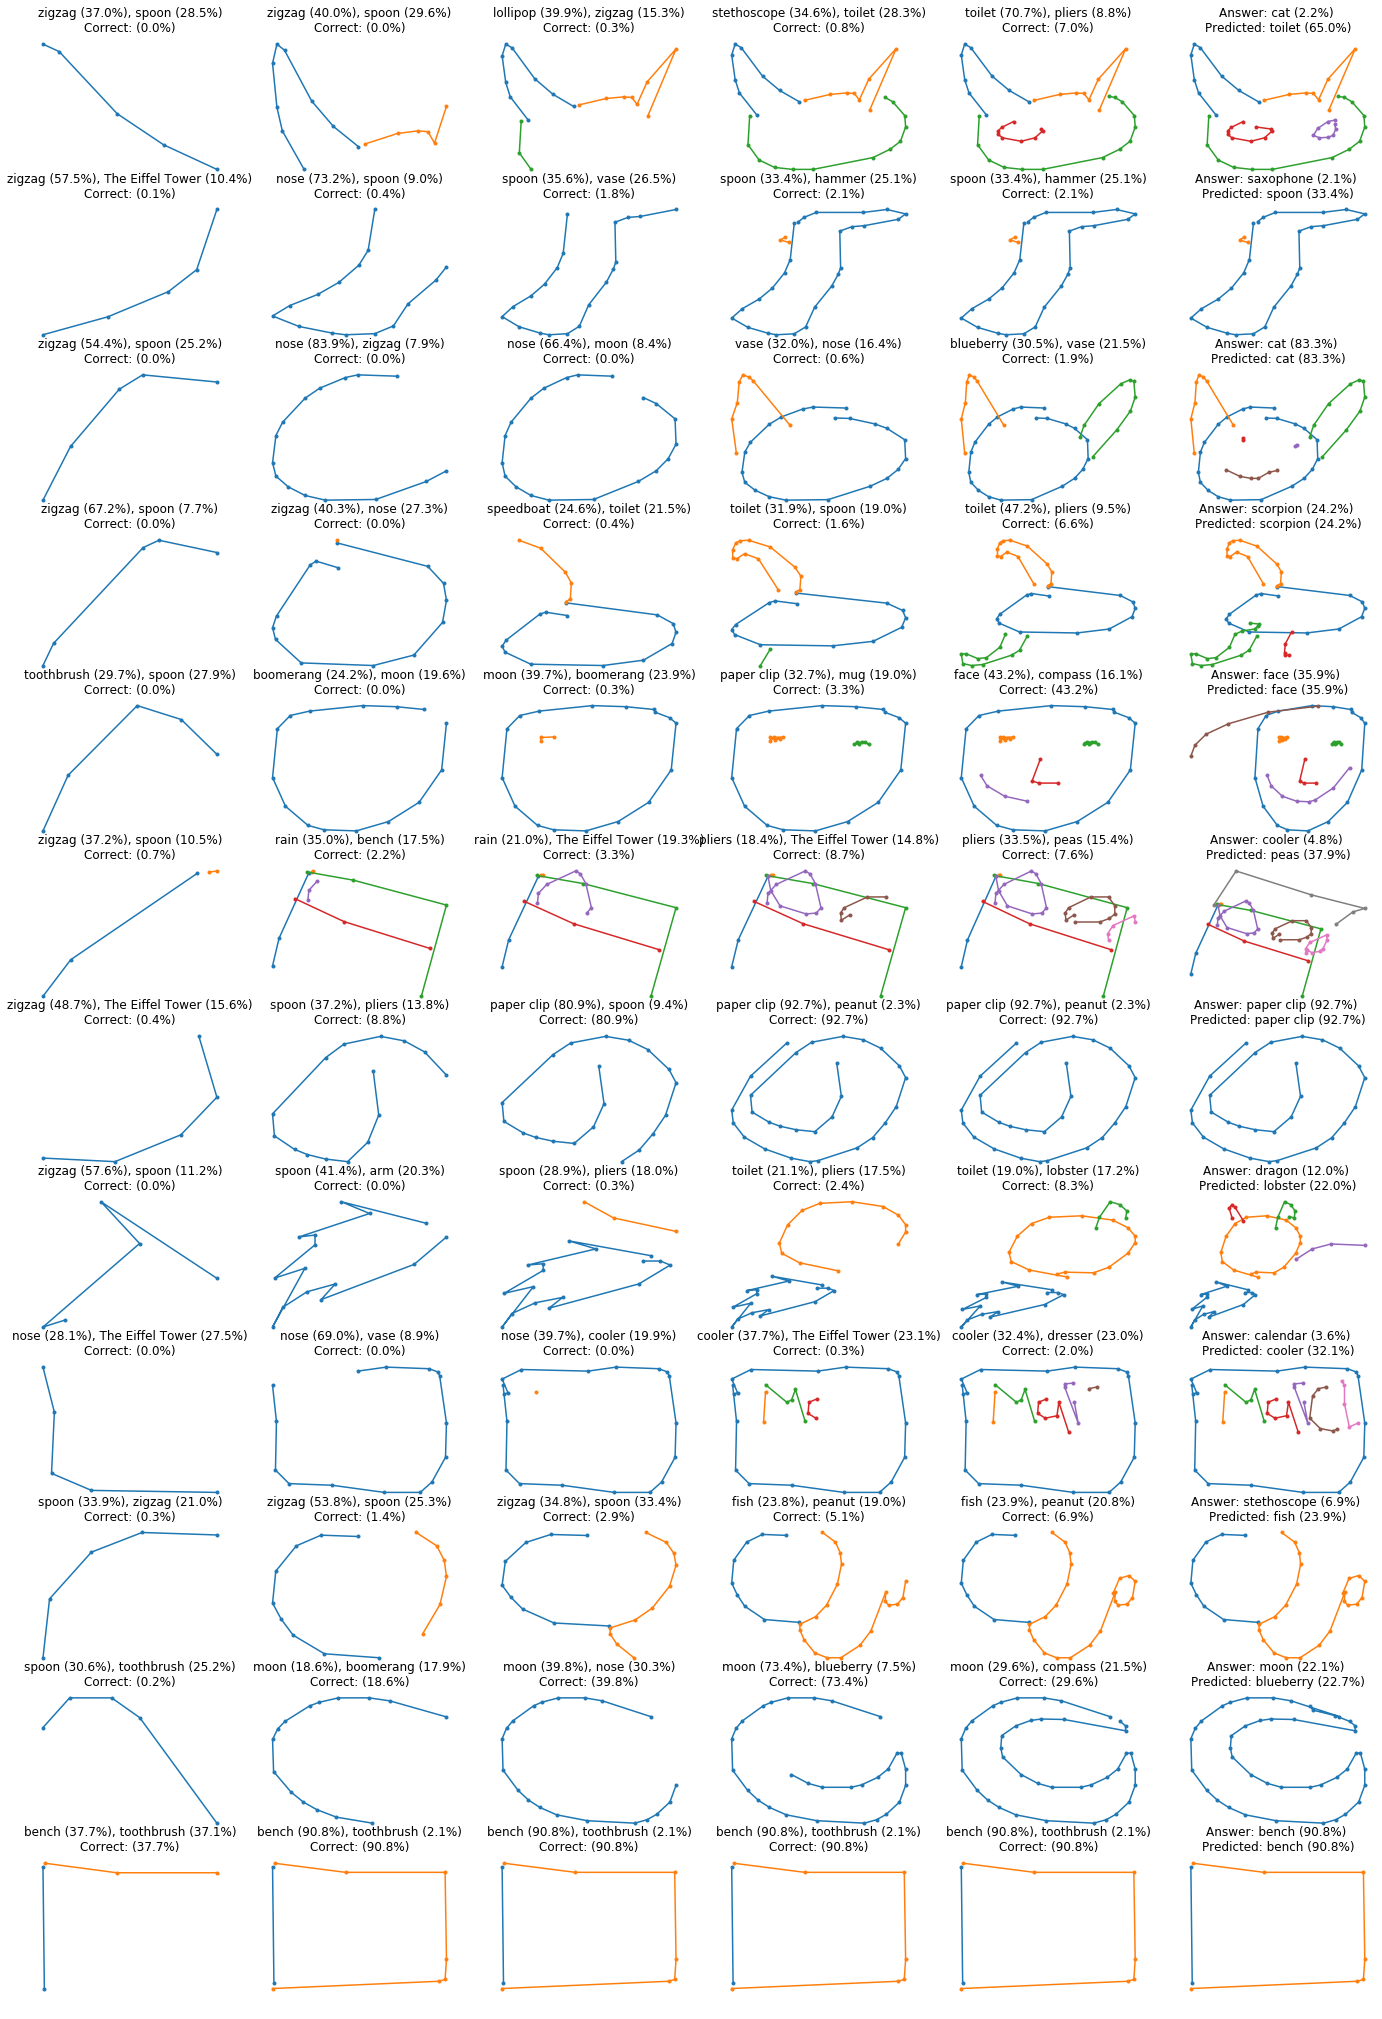

In [15]:
points_to_use = [5, 15, 20, 30, 40, 50]
points_to_user = [108]
samples = 12
word_dex = lambda x: word_encoder.classes_[x]
rand_idxs = np.random.choice(range(test_X.shape[0]), size = samples)
fig, m_axs = plt.subplots(len(rand_idxs), len(points_to_use), figsize = (24, samples/8*24))
for c_id, c_axs in zip(rand_idxs, m_axs):
    res_idx = np.argmax(test_y[c_id])
    goal_cat = word_encoder.classes_[res_idx]
    
    for pt_idx, (pts, c_ax) in enumerate(zip(points_to_use, c_axs)):
        test_arr = test_X[c_id, :].copy()
        test_arr[pts:] = 0 # short sequences make CudnnLSTM crash, ugh 
        stroke_pred = stroke_read_model.predict(np.expand_dims(test_arr,0))[0]
        top_10_idx = np.argsort(-1*stroke_pred)[:10]
        top_10_sum = np.sum(stroke_pred[top_10_idx])
        
        test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
        lab_idx = np.cumsum(test_arr[:,2]-1)
        for i in np.unique(lab_idx):
            c_ax.plot(test_arr[lab_idx==i,0], 
                    np.max(test_arr[:,1])-test_arr[lab_idx==i,1], # flip y
                      '.-')
        c_ax.axis('off')
        if pt_idx == (len(points_to_use)-1):
            c_ax.set_title('Answer: %s (%2.1f%%) \nPredicted: %s (%2.1f%%)' % (goal_cat, 100*stroke_pred[res_idx]/top_10_sum, word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum))
        else:
            c_ax.set_title('%s (%2.1f%%), %s (%2.1f%%)\nCorrect: (%2.1f%%)' % (word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum, 
                                                                 word_dex(top_10_idx[1]), 100*stroke_pred[top_10_idx[1]]/top_10_sum, 
                                                                 100*stroke_pred[res_idx]/top_10_sum))

# Submission

In [19]:
sub_df = pd.read_csv('~/test_simplified.csv')
sub_df['drawing'] = sub_df['drawing'].map(_stack_it)
sub_vec = np.stack(sub_df['drawing'].values, 0)
sub_pred = stroke_read_model.predict(sub_vec, verbose=True, batch_size=4096)

112199/112199 [==============================] - 4s 34us/step


In [20]:
top_3_pred = [word_encoder.classes_[np.argsort(-1*c_pred)[:3]] for c_pred in sub_pred]

In [21]:
top_3_pred = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_pred]
top_3_pred[:3]

['tractor truck toilet', 'mouth bench truck', 'bush zigzag spoon']

# Show some predictions on the submission dataset

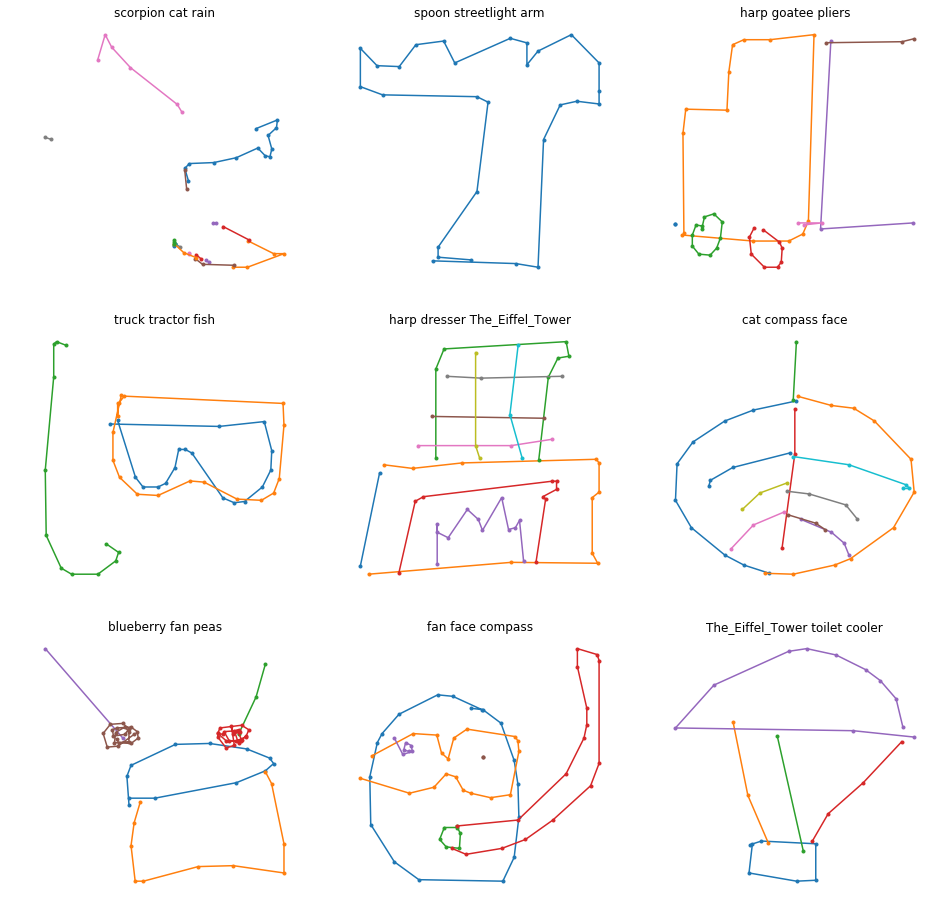

In [22]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(sub_vec.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = sub_vec[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(top_3_pred[c_id])

In [23]:
sub_df['word'] = top_3_pred
sub_df[['key_id', 'word']].to_csv('modrnnsub.csv', index=False)